# Analyze Ariane Deduced Tranports

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
from scipy import stats
import scipy

%matplotlib inline

SUBDIR_TMPL = '{:%d%b%y}'
other_nan = ['********************']

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Find the daily averaged squared velocity at a key spot

In [2]:
u_vel   = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DuVelocity1hV1')
grid    = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1')

In [3]:
iY = 341-1; iX = 283-1; iZ = 10 

In [4]:
velocitypt1 = u_vel.uVelocity.sel(time ='2014', depth=iZ, gridX=iX, gridY=iY, method='nearest')
velocitypt2 = u_vel.uVelocity.sel(time ='2015', depth=iZ, gridX=iX, gridY=iY, method='nearest')
velocitypt3 = u_vel.uVelocity.sel(time ='2016', depth=iZ, gridX=iX, gridY=iY, method='nearest')

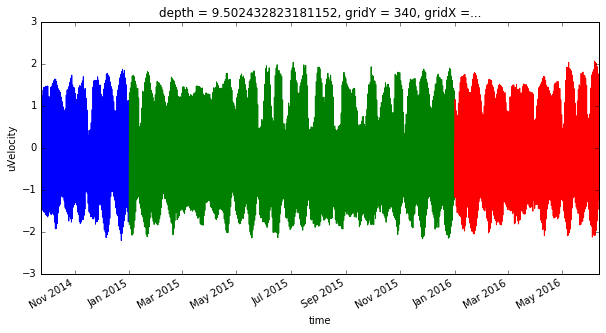

In [5]:
# Yes, do run this.  Its gets the data which makes the next cell happy.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
velocitypt1.plot()
velocitypt2.plot()
velocitypt3.plot()

In [7]:
velocity = xr.concat([velocitypt1, velocitypt2, velocitypt3], dim='time')
velsquared = velocity * velocity
day_avg_tide_vel = velsquared.resample('1D', dim='time', how='mean')

In [12]:
day_avg_tide_pd = day_avg_tide_vel.to_dataframe()

day_avg_tide_pd.to_csv('day_avg_tide_pd.csv')

In [ ]:
day_avg_tide_pd = day_avg_tide_pd.drop('depth', 1)
day_avg_tide_pd = day_avg_tide_pd.drop('gridY', 1)
day_avg_tide_pd = day_avg_tide_pd.drop('gridX', 1)
print (day_avg_tide_pd)

In [ ]:
#print(day_avg_tide_vel[:])
low_pass_tide = pd.rolling_mean(day_avg_tide_pd, 4, center=True)
print (low_pass_tide)

In [ ]:
day_avg_tide_pd.plot()
low_pass_tide.plot()

## Input Required Ariane Results

In [ ]:
rawstats = ['sn', 's1x', 's1x2']
stat = {}
mean = np.zeros((3))
stdev = np.zeros((1))


FRtoBPdir = '/ocean/sallen/allen/research/MEOPAR/Ariane/BackFluxes/StatsFiles/'
FRtoBP = pd.DataFrame(data=None, index=None, 
                           columns=['time', 'depth-mean', 'depth-std',
                                   'salinity-mean', 'flux'],
                           dtype=None, copy=False)    

VStoBPdir = '/ocean/sallen/allen/research/MEOPAR/Ariane/BackFluxesSouth/StatsFiles/'
VStoBP = pd.DataFrame(data=None, index=None, 
                           columns=['time', 'depth-mean', 'depth-std',
                                   'salinity-mean','flux'],
                           dtype=None, copy=False) 

startdate = datetime.date(2014, 10, 27) + datetime.timedelta(days=15)
#startdate = datetime.date(2015, 9, 1)
enddate = datetime.date(2016, 3, 13)
delt = enddate - startdate
for nday in range(delt.days):
    rundate = startdate + datetime.timedelta(days=nday)
    for region, database, dire in zip(['FraserRidge', 'VictoriaSill'], [FRtoBP, VStoBP], [FRtoBPdir, VStoBPdir]): 
        for stattype in rawstats:
            stat[stattype] = pd.read_csv(os.path.join(dire,
                                        stattype+'.'+SUBDIR_TMPL.format(rundate).lower()), 
                                        index_col=0, na_values=other_nan)
            stat[stattype].index = [x.strip() for x in stat[stattype].index]
        for i, parameter in enumerate(['depth', 'sal']):
            themean = stat['s1x'][parameter]/stat['sn']['sn']                
            mean[i] = getattr(themean, region)
        for i, parameter in enumerate(['depth']):
            thestdev = np.sqrt(np.abs((stat['s1x2'][parameter] - 
                                     stat['s1x'][parameter]**2 / stat['sn']['sn'])
                                    / (stat['sn']['sn']-1)))
            stdev[i] = getattr(thestdev, region)
                
        mean[2] = getattr(stat['sn']['flux'], region)
        database.loc[nday] = [rundate, mean[0], stdev[0], mean[1], mean[2]]
FRtoBP =FRtoBP.set_index('time')
VStoBP =VStoBP.set_index('time')



In [ ]:
ax = FRtoBP['flux'].plot()
low_pass_tide.plot(ax=ax)

## Look at Raw Transports

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.index, FRtoBP['flux'])
ax.plot(VStoBP.index, (VStoBP['salinity-mean']-30)*20000)
ax.plot(low_pass_tide.index, low_pass_tide['uVelocity']*50000.)

In [ ]:
c1=np.correlate(FRtoBP['flux']-np.mean(FRtoBP['flux']),
               VStoBP['salinity-mean']-np.mean(VStoBP['salinity-mean']), mode='full')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
scale1 = np.std(FRtoBP['flux']-np.mean(FRtoBP['flux']))
scale2 = np.std(VStoBP['salinity-mean']-np.mean(VStoBP['salinity-mean']))
scaled_c1 = c1/(scale1*scale2)/c1.shape[0]
ax.plot(scaled_c1)
print (scaled_c1.max(), scaled_c1.argmax(), c1.shape[0]/2., FRtoBP.index.shape)

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(VStoBP['salinity-mean'], FRtoBP['flux'])
print (slope, intercept, r_value, p_value, std_err)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(VStoBP['salinity-mean'], FRtoBP['flux'], 'o')
ax.plot(VStoBP['salinity-mean'], -604459.313736+20234.2945168*VStoBP['salinity-mean'], 'o')
print (r_value**2)

In [ ]:
step_two = FRtoBP['flux'] - (-604459.313736+20234.2945168*VStoBP['salinity-mean'])
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.index, step_two)
ax.plot(low_pass_tide.index, low_pass_tide['uVelocity']*50000.-50000)

In [ ]:
print(low_pass_tide.index[-90], FRtoBP.index[-1], low_pass_tide.index[48], FRtoBP.index[0])
c1=np.correlate(step_two,
              low_pass_tide['uVelocity'][48+1:-89+1]-np.mean(low_pass_tide['uVelocity'][48+1:-89+1]), mode='full')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
scale1 = np.std(step_two)
scale2 = np.std(low_pass_tide['uVelocity'][48:-89]-np.mean(low_pass_tide['uVelocity'][48:-89]))
scaled_c1 = c1/(scale1*scale2)/c1.shape[0]
ax.plot(scaled_c1)
print (scaled_c1.max(), scaled_c1.argmax(), c1.shape[0]/2. )
ax.plot([487, 487], [-0.20, 0.20])
print (step_two.shape, low_pass_tide['uVelocity'][48+1:-89+1].shape)

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(low_pass_tide['uVelocity'][48+1:-89+1], 
                                                               step_two)
print (slope, intercept, r_value, p_value, std_err)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(low_pass_tide['uVelocity'][48+1:-89+1], step_two, 'o')
ax.plot(low_pass_tide['uVelocity'][48+1:-89+1], intercept+slope*low_pass_tide['uVelocity'][48+1:-89+1], 'o')
print (r_value**2)

In [ ]:
step_three = step_two - (intercept + slope* low_pass_tide['uVelocity'][48:-89].shift(periods=1))
print (step_three.shape, step_two.shape,low_pass_tide['uVelocity'][48+1:-89+1].shape )
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.index, step_three)

In [ ]:
X = np.fft.fft(np.array(step_three[1:]))
Z = np.fft.fft(np.array(step_two[1:]))
Y = np.fft.fft(np.array(FRtoBP['flux']))
omega = np.fft.fftfreq(step_three[1:].shape[0])
omega3 = np.fft.fftfreq(step_two[1:].shape[0])
omega2 = np.fft.fftfreq(FRtoBP['flux'].shape[0])
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(omega2, np.absolute(Y), linewidth=3)
ax.plot(omega3, np.absolute(Z), linewidth=2)
ax.plot(omega, np.absolute(X), 'r')
ax.set_ylim((0, 2e6))
ax.set_xlim((0, 0.2))
ax.plot(1/14.75, 1e6, 'or')
ax.plot(1/27.5, 1e6, 'or')
ax.plot(0.5/14.75+0.5/27.5, 1e6, 'og')

In [ ]:
X = np.fft.fft(np.array(VStoBP['flux']/50000.))
Z = np.fft.fft(np.array(VStoBP['salinity-mean']))
Y = np.fft.fft(np.array(FRtoBP['flux']/50000.))
A = np.fft.fft(np.array(FRtoBP['salinity-mean']/5.))
omega = np.fft.fftfreq(VStoBP['flux'].shape[0])
omega3 = np.fft.fftfreq(VStoBP['salinity-mean'].shape[0])
omega2 = np.fft.fftfreq(FRtoBP['flux'].shape[0])
omega4 = np.fft.fftfreq(FRtoBP['salinity-mean'].shape[0])
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(omega2, np.absolute(Y), linewidth=3, label='VStoBP, flux')
ax.plot(omega3, np.absolute(Z), linewidth=2, label='VS, salinity')
ax.plot(omega, np.absolute(X), label='FRtoBP, flux')
ax.plot(omega4, np.absolute(A), label='FR, salinity')
ax.set_ylim((0, 100))
ax.set_xlim((0, 0.2))
ax.plot(1/14.75, 50, 'or')
ax.plot(1/27.5, 50, 'or')
ax.plot(0.5/14.75+0.5/27.5, 50, 'og')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.index, step_three/20000.+25.)
ax.plot(FRtoBP.index, FRtoBP['salinity-mean'])
print (fr[0])

In [ ]:
c1=np.correlate(step_three[1:], FRtoBP['salinity-mean']-np.mean(FRtoBP['salinity-mean']), 
                mode='full')
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
scale1 = np.std(step_three[1:])
scale2 = np.std(FRtoBP['salinity-mean']-np.mean(FRtoBP['salinity-mean']))
scaled_c1 = c1/(scale1*scale2)/c1.shape[0]
ax.plot(scaled_c1)
print (scaled_c1.min(), scaled_c1.argmin(), c1.shape[0]/2., step_three.index.shape, fr.index.shape)
ax.plot([487, 487], [-0.15, 0.14])

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(FRtoBP['salinity-mean'].shift(periods=-1)[:-1], 
                                                               step_three[1:])
print (slope, intercept, r_value, p_value, std_err)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(FRtoBP['salinity-mean'].shift(periods=-1)[:-1], step_three[1:], 'o')
ax.plot(FRtoBP['salinity-mean'].shift(periods=-1)[:-1], 
        intercept+slope*FRtoBP['salinity-mean'].shift(periods=-1)[:-1], 'o')

In [ ]:
step_four = step_three - (intercept + slope* FRtoBP['salinity-mean'].shift(periods=-1)[:-1])
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(FRtoBP.index, FRtoBP['flux'] - np.mean(FRtoBP['flux']))
ax.plot(FRtoBP.index, step_two)
ax.plot(FRtoBP.index, step_three)
ax.plot(FRtoBP.index, step_four)
print (np.std(FRtoBP['flux'] - np.mean(FRtoBP['flux'])), np.std(step_two), np.std(step_three), np.std(step_four))

In [ ]:
X = np.fft.fft(np.array(FRtoBP['flux'] - np.mean(FRtoBP['flux'])))
Z = np.fft.fft(np.array(step_two))
Y = np.fft.fft(np.array(step_three[1:]))
A = np.fft.fft(np.array(step_four[1:-1]))
omega = np.fft.fftfreq(FRtoBP['flux'].shape[0])
omega3 = np.fft.fftfreq(step_two.shape[0])
omega2 = np.fft.fftfreq(step_three.shape[0]-1)
omega4 = np.fft.fftfreq(step_four.shape[0]-2)
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(omega2, np.absolute(Y), linewidth=3, label='step_three')
ax.plot(omega3, np.absolute(Z), linewidth=2, label='step_two')
ax.plot(omega, np.absolute(X), label='original')
ax.plot(omega4, np.absolute(A), label='step_four')
ax.set_xlim((0, 0.2))
ax.plot(1/14.75, 50, 'or')
ax.plot(1/27.5, 50, 'or')
ax.plot(0.5/14.75+0.5/27.5, 50, 'og')
ax.legend()

## Normalize the Transport

Idea is to normalize by a velocity = sqrt(g'h) a width and a depth.  For now, we will just use the sqrt(salinity difference) as the only component that actually changes

In [ ]:
difference = VStoBP - FRtoBP
TransportScale = np.sqrt(difference.loc[:, 'salinity-mean'])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(difference.time, TransportScale)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(FRtoBP.time, FRtoBP.loc[:, 'flux']/TransportScale)
ax.plot(VStoBP.time, VStoBP.loc[:, 'flux']/TransportScale)
print ('Fraser Ridge to Boundary Pass')
print (np.mean(FRtoBP.loc[:, 'flux']/TransportScale))
print (np.std(FRtoBP.loc[:, 'flux']/TransportScale))
print ('Normalized Variance = ', np.std(FRtoBP.loc[:, 'flux']/TransportScale) / 
       np.mean(FRtoBP.loc[:, 'flux']/TransportScale))
print ('Victoria Sill to Boundary Pass')
print (np.mean(VStoBP.loc[:, 'flux']/TransportScale))
print (np.std(VStoBP.loc[:, 'flux']/TransportScale))
print ('Normalized Variance = ', np.std(VStoBP.loc[:, 'flux']/TransportScale) / 
       np.mean(VStoBP.loc[:, 'flux']/TransportScale))

## Estimate a Richardson Number

The Richardson number should be Brunt-Vaisala squared divided by the velocity shear squared.  Here we will use g'/h as a measure of the stratification and U/h as the velocity shear to give us a Richardson number of
g'h/U^2.

And until I do everything nice, we will approximate this as the difference in Salinity divided by the velocity squared.

In [ ]:
Ri = (VStoBP-FRtoBP)/day_avg_tide_vel
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Ri.time, Ri.loc[:, 'salinity-mean'], 'r')
ax.plot(FRtoBP.time, FRtoBP.loc[:, 'flux']/TransportScale/2000.)
ax.plot(VStoBP.time, VStoBP.loc[:, 'flux']/TransportScale/2000.)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Ri.loc[:, 'salinity-mean'], FRtoBP.loc[:, 'flux']/TransportScale, 'o')
ax.plot(Ri.loc[:, 'salinity-mean'], VStoBP.loc[:, 'flux']/TransportScale, 'o')

### Find the maximum lagged correlation

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
c1 = np.correlate(Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), 
                     FRtoBP.loc[:, 'flux']/TransportScale-np.mean(FRtoBP.loc[:, 'flux']/TransportScale), 
                     mode='full')
ax.plot(c1,'o-')
c2 = np.correlate(Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), 
                     VStoBP.loc[:, 'flux']/TransportScale-np.mean(VStoBP.loc[:, 'flux']/TransportScale), 
                     mode='full')
ax.plot(c2,'o-')
c3 = np.correlate(Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), 
                     Ri.loc[:, 'salinity-mean']-np.mean(Ri.loc[:, 'salinity-mean']), mode='full')
#ax.plot(c3*1000,'o-')

shiftFR = np.argmax(c1) - np.argmax(c3)
shiftVS = np.argmax(c2) - np.argmax(c3)
print (shiftFR, shiftVS)

In [ ]:
Riadv = Ri
Riadv['time'] = Riadv['time'] + datetime.timedelta(days=int(shiftVS))
Riback = Ri
Riback['time'] = Riadv['time'] + datetime.timedelta(days=int(shiftFR))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(Riback.loc[:, 'salinity-mean'], FRtoBP.loc[:, 'flux']/TransportScale, 'o')
ax.plot(Riadv.loc[:, 'salinity-mean'], VStoBP.loc[:, 'flux']/TransportScale, 'o')